In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('EURUSD1_trades.csv')

In [3]:
df.head()

,ts_entry,ts_exit,direction,entry,stop,target,rr,outcome,bars_to_outcome,mfe,mae,r_result,balance_before,balance_after,cash_result
0,2025-04-21 21:28:00,NaN,bearish,1.15074,1.15159,1.149720,1.2,timeout,NaN,0.364706,-0.776471,0.0,10000.0,10000.0,0.0
1,2025-04-21 23:08:00,NaN,bullish,1.15214,1.15076,1.153796,1.2,timeout,NaN,0.050725,-0.384058,0.0,10000.0,10000.0,0.0
2,2025-04-22 01:18:00,NaN,bearish,1.14881,1.15149,1.145594,1.2,timeout,NaN,0.097015,-0.376866,0.0,10000.0,10000.0,0.0
3,2025-04-22 01:28:00,NaN,bearish,1.14886,1.15118,1.146076,1.2,timeout,NaN,0.017241,-0.413793,0.0,10000.0,10000.0,0.0
4,2025-04-22 05:48:00,NaN,bullish,1.15439,1.15181,1.157486,1.2,timeout,NaN,0.065891,-0.453488,0.0,10000.0,10000.0,0.0


In [1]:
# Load trades with robust parsing
import pandas as pd, numpy as np
from pathlib import Path

csv_path = Path('backtest/results/EURUSD1_trades.csv')
if not csv_path.exists():
    # fallback if run from inside results folder
    alt = Path('EURUSD1_trades.csv')
    if alt.exists():
        csv_path = alt

# Try reading; skip malformed lines
try:
    df = pd.read_csv(csv_path, parse_dates=['ts_entry','ts_exit'], on_bad_lines='skip')
except Exception as e:
    print('Primary read failed, retrying without date parse:', e)
    df = pd.read_csv(csv_path, on_bad_lines='skip')
    # Convert manually if present
    for c in ['ts_entry','ts_exit']:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')

expected_cols = {'ts_entry','outcome'}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}. Available: {df.columns.tolist()}')

# Filter out rows without entry time
df = df[df.ts_entry.notna()].copy()

# Time features
df['hour'] = df.ts_entry.dt.hour
df['dow'] = df.ts_entry.dt.dayofweek  # 0=Mon

# Outcome flags
df['is_win'] = (df.outcome == 'win').astype(int)
df['is_loss'] = (df.outcome == 'loss').astype(int)
df['is_timeout'] = (df.outcome == 'timeout').astype(int)

print('Total trades:', len(df), '| Wins:', df.is_win.sum(), '| Losses:', df.is_loss.sum(), '| Timeouts:', df.is_timeout.sum())
df.head()

Total trades: 500 | Wins: 28 | Losses: 45 | Timeouts: 427


,ts_entry,ts_exit,direction,entry,stop,target,rr,outcome,bars_to_outcome,mfe,mae,r_result,balance_before,balance_after,cash_result,hour,dow,is_win,is_loss,is_timeout
0,2025-04-21 21:28:00,NaT,bearish,1.15074,1.15159,1.149720,1.2,timeout,NaN,0.364706,-0.776471,0.0,10000.0,10000.0,0.0,21,0,0,0,1
1,2025-04-21 23:08:00,NaT,bullish,1.15214,1.15076,1.153796,1.2,timeout,NaN,0.050725,-0.384058,0.0,10000.0,10000.0,0.0,23,0,0,0,1
2,2025-04-22 01:18:00,NaT,bearish,1.14881,1.15149,1.145594,1.2,timeout,NaN,0.097015,-0.376866,0.0,10000.0,10000.0,0.0,1,1,0,0,1
3,2025-04-22 01:28:00,NaT,bearish,1.14886,1.15118,1.146076,1.2,timeout,NaN,0.017241,-0.413793,0.0,10000.0,10000.0,0.0,1,1,0,0,1
4,2025-04-22 05:48:00,NaT,bullish,1.15439,1.15181,1.157486,1.2,timeout,NaN,0.065891,-0.453488,0.0,10000.0,10000.0,0.0,5,1,0,0,1


<Figure size 1200x400 with 0 Axes>

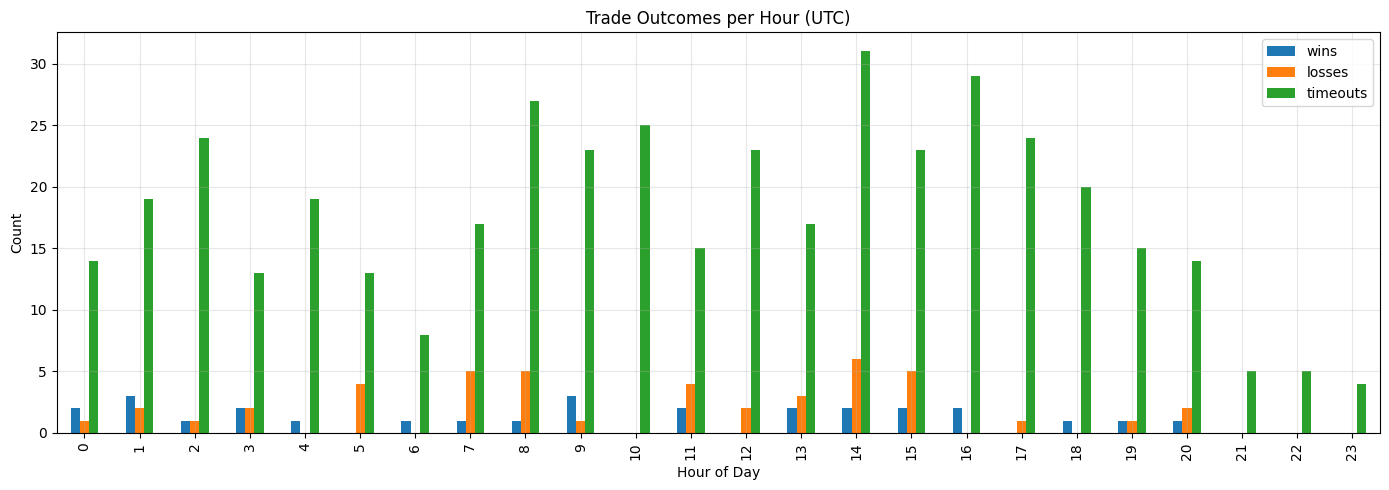

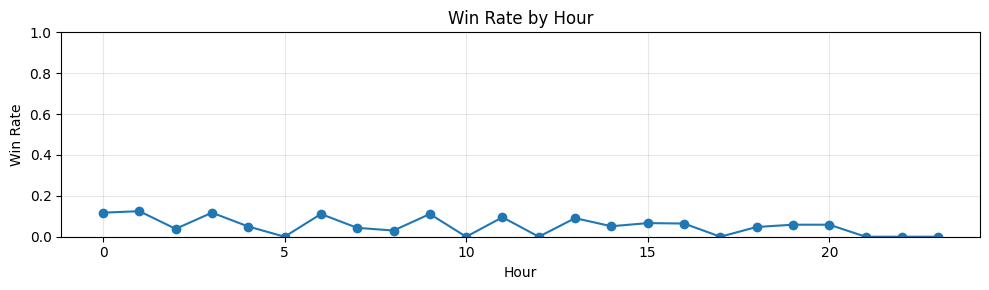

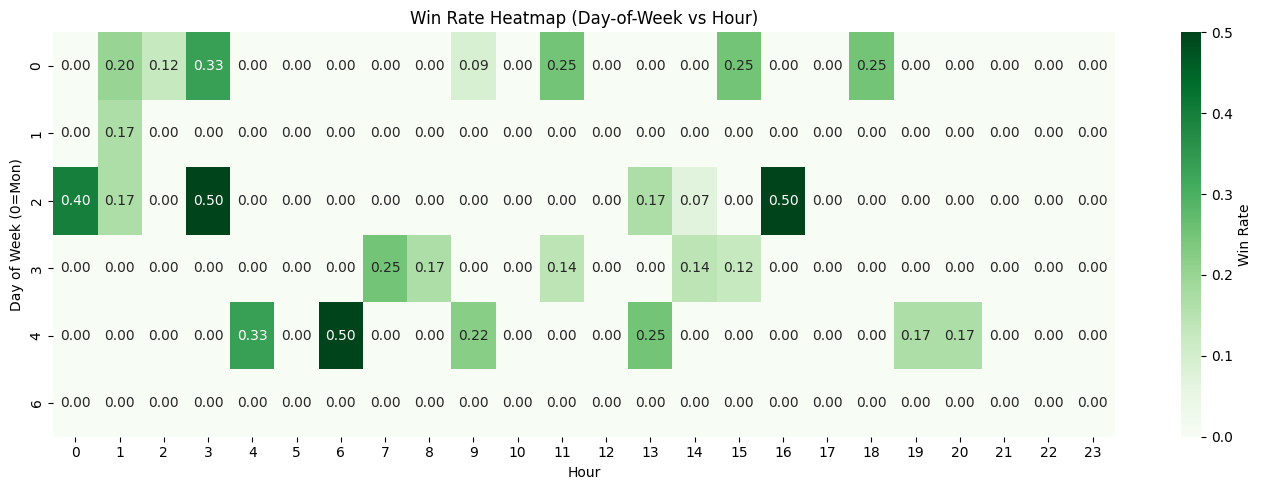

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate wins / losses per hour
hour_stats = df.groupby('hour').agg(wins=('is_win','sum'), losses=('is_loss','sum'), timeouts=('is_timeout','sum'), total=('outcome','count'))
# Win rate per hour (avoid div by zero)
hour_stats['win_rate'] = (hour_stats['wins'] / hour_stats['total']).fillna(0)

plt.figure(figsize=(12,4))
ax = hour_stats[['wins','losses','timeouts']].plot(kind='bar', stacked=False, figsize=(14,5))
plt.title('Trade Outcomes per Hour (UTC)')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(hour_stats.index, hour_stats.win_rate, marker='o')
plt.title('Win Rate by Hour')
plt.xlabel('Hour')
plt.ylabel('Win Rate')
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Heatmap Day-of-week vs Hour
pivot = df.pivot_table(values='is_win', index='dow', columns='hour', aggfunc=['sum','count'])
# pivot is multiindex columns; compute win rate
win_counts = pivot['sum']
trade_counts = pivot['count']
win_rate_matrix = (win_counts / trade_counts).fillna(0)

plt.figure(figsize=(14,5))
sns.heatmap(win_rate_matrix, annot=True, fmt='.2f', cmap='Greens', cbar_kws={'label':'Win Rate'})
plt.title('Win Rate Heatmap (Day-of-Week vs Hour)')
plt.ylabel('Day of Week (0=Mon)')
plt.xlabel('Hour')
plt.tight_layout()
plt.show()

In [9]:
import plotly.express as px

# Prepare timeline scatter (one point per trade)
plot_df = df.copy()
plot_df['result_color'] = np.select(
    [plot_df.is_win==1, plot_df.is_loss==1, plot_df.is_timeout==1],
    ['green','red','orange'], 'gray'
)
fig = px.scatter(
    plot_df,
    x='ts_entry',
    y='hour',
    color='outcome',
    title='Trade Outcomes Over Time (Y=Hour of Day)',
    hover_data=['direction','outcome']
)
fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.show()

Session Performance:
         trades  wins  losses  timeouts  win_rate
session                                          
Asia        153    11      15       127  0.071895
US          202    11      18       173  0.054455
Europe      131     6      12       113  0.045802
Off          14     0       0        14  0.000000
Best session by win rate: Asia
Worst session by win rate: Off


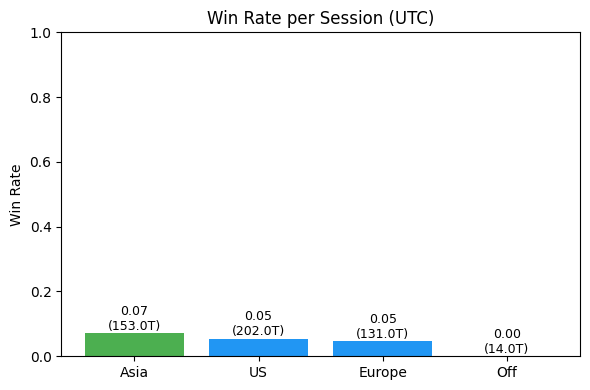


Directional performance by session:
                   trades  wins  losses  win_rate
session direction                                
Asia    bearish        74     7      11  0.094595
        bullish        79     4       4  0.050633
Europe  bearish        76     1       6  0.013158
        bullish        55     5       6  0.090909
Off     bearish         4     0       0  0.000000
        bullish        10     0       0  0.000000
US      bearish        89     7       7  0.078652
        bullish       113     4      11  0.035398


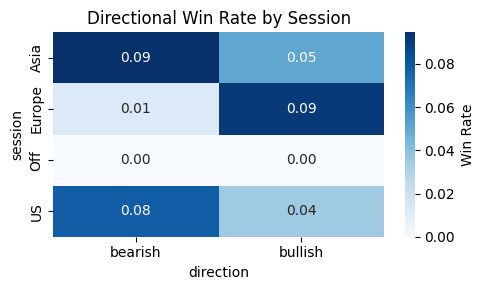

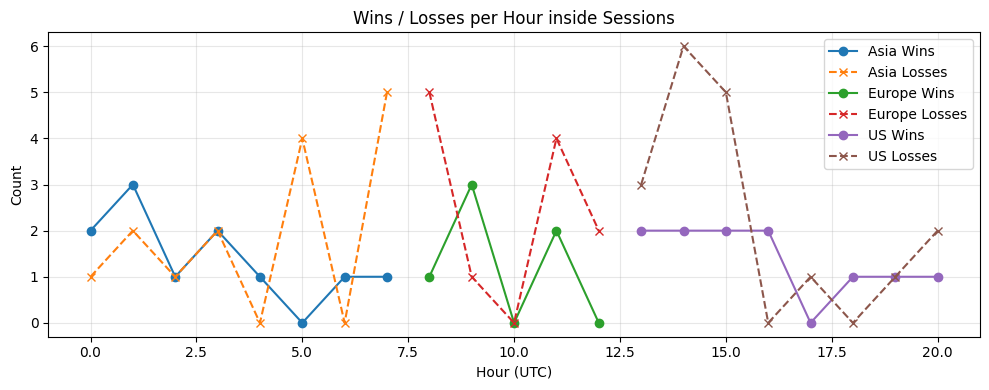

{'Asia': {'trades': 153,
  'wins': 11,
  'losses': 15,
  'timeouts': 127,
  'win_rate': 0.0718954248366013},
 'Europe': {'trades': 131,
  'wins': 6,
  'losses': 12,
  'timeouts': 113,
  'win_rate': 0.04580152671755725},
 'Off': {'trades': 14,
  'wins': 0,
  'losses': 0,
  'timeouts': 14,
  'win_rate': 0.0},
 'US': {'trades': 202,
  'wins': 11,
  'losses': 18,
  'timeouts': 173,
  'win_rate': 0.054455445544554455}}

In [10]:
# --- Session (Asia / Europe / US) Analysis ---
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

if 'hour' not in df.columns:
    df['hour'] = df.ts_entry.dt.hour

# Define sessions in UTC (simplified, non-overlapping)
# Asia:   00-07, Europe: 08-12, US: 13-20, Off: others
# You can adjust ranges below easily.

def classify_session(h):
    if 0 <= h <= 7: return 'Asia'
    if 8 <= h <= 12: return 'Europe'
    if 13 <= h <= 20: return 'US'
    return 'Off'

df['session'] = df['hour'].apply(classify_session)

session_stats = df.groupby('session').agg(
    trades=('outcome','count'),
    wins=('is_win','sum'),
    losses=('is_loss','sum'),
    timeouts=('is_timeout','sum')
)
session_stats['win_rate'] = (session_stats['wins'] / session_stats['trades']).replace([np.inf, np.nan], 0)

# Filter out Off if no need
display_stats = session_stats.sort_values('win_rate', ascending=False)
print('Session Performance:')
print(display_stats)

best_session = display_stats['win_rate'].idxmax() if len(display_stats)>0 else None
worst_session = display_stats[display_stats.trades>0]['win_rate'].idxmin() if (display_stats.trades>0).any() else None
print(f"Best session by win rate: {best_session}")
print(f"Worst session by win rate: {worst_session}")

# Plot win rate per session
plt.figure(figsize=(6,4))
plt.bar(display_stats.index, display_stats['win_rate'], color=['#4caf50' if s==best_session else '#ff7043' if s==worst_session else '#2196f3' for s in display_stats.index])
plt.title('Win Rate per Session (UTC)')
plt.ylabel('Win Rate')
plt.ylim(0,1)
for i,(s,row) in enumerate(display_stats.iterrows()):
    plt.text(i, row.win_rate+0.01, f"{row.win_rate:.2f}\n({row.trades}T)", ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Directional performance per session (if direction column available)
if 'direction' in df.columns:
    dir_stats = df.groupby(['session','direction']).agg(
        trades=('outcome','count'),
        wins=('is_win','sum'),
        losses=('is_loss','sum')
    )
    dir_stats['win_rate'] = (dir_stats['wins']/dir_stats['trades']).replace([np.inf,np.nan],0)
    print('\nDirectional performance by session:')
    print(dir_stats)
    # Pivot for heatmap
    pivot_dir = dir_stats.reset_index().pivot_table(values='win_rate', index='session', columns='direction', fill_value=0)
    plt.figure(figsize=(5,3))
    sns.heatmap(pivot_dir, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label':'Win Rate'})
    plt.title('Directional Win Rate by Session')
    plt.tight_layout()
    plt.show()

# Hour distribution inside each session (wins vs losses)
plt.figure(figsize=(10,4))
for sess in ['Asia','Europe','US']:
    subset = df[df.session==sess]
    if subset.empty: continue
    wins_per_hour = subset.groupby('hour')['is_win'].sum()
    losses_per_hour = subset.groupby('hour')['is_loss'].sum()
    plt.plot(wins_per_hour.index, wins_per_hour.values, marker='o', label=f'{sess} Wins')
    plt.plot(losses_per_hour.index, losses_per_hour.values, marker='x', linestyle='--', label=f'{sess} Losses')
plt.title('Wins / Losses per Hour inside Sessions')
plt.xlabel('Hour (UTC)')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Summary dictionary (could be saved if needed)
session_summary = session_stats.to_dict('index')
session_summary